Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma Cancer detection/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Melanoma Cancer detection/Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "training"
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split = 0.2,
    image_size = (img_height,img_width),
    batch_size = batch_size,
    subset = "validation"
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


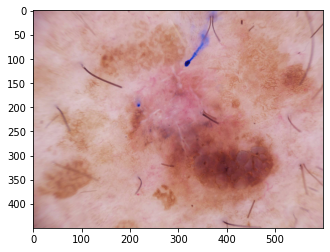

In [9]:
# Let us visualize one image randomly
image = plt.imread(str(list(data_dir_train.glob(class_names[1]+'/*.jpg'))[2]))
plt.imshow(image)

### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

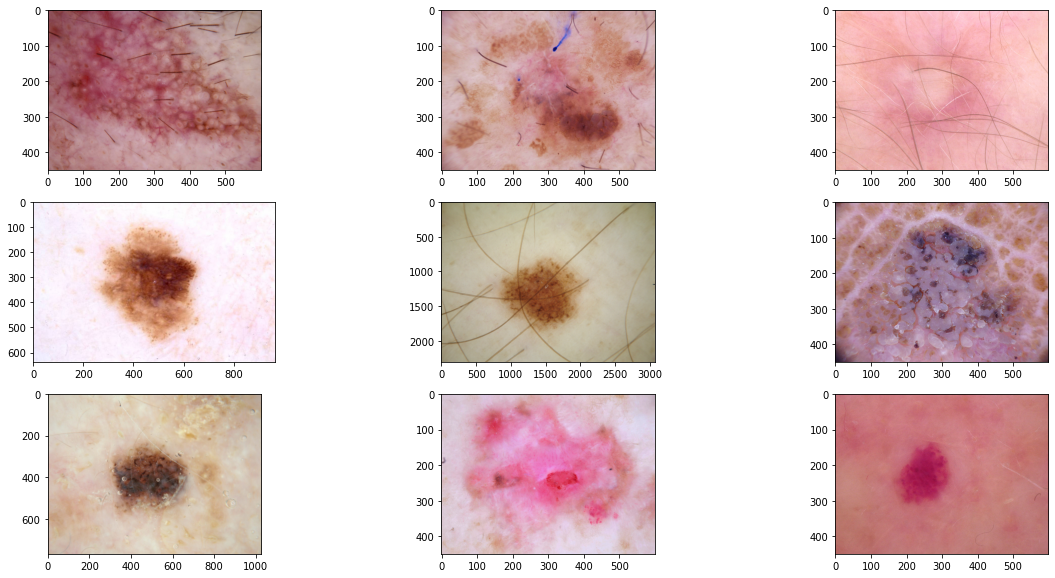

In [10]:
### your code goes here, you can use training or validation data to visualize
import matplotlib.pyplot as plt

plt.figure(figsize = (20,10))
for i in range(9):
  plt.subplot(3, 3, i+1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[2]))
  plt.imshow(image)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [38]:
### Your code goes here
classes_nums = 9

#A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #We slide over the feature map and extract tiles of a specified size
  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size. 
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #Adding another Pooling layer
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size.
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size. 
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  # Let us add some dropouts
  layers.Dropout(0.25),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer (Dense layer)
  layers.Dense(128, activation='relu'),

  # Output neuron
  layers.Dense(classes_nums)
])



### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [39]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',       # We choose adam optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [40]:
# View the summary of all layers
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_8 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 180, 180, 64)      1792      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 90, 90, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 90, 90, 128)       73856     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 45, 45, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 45, 45, 128)      

### Train the model

In [41]:
# Lets train the model with 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 75ms/step - loss: 2.0966 - accuracy: 0.1886 - val_loss: 2.0310 - val_accuracy: 0.2237
Epoch 2/20
56/56 [==============================] - 4s 72ms/step - loss: 1.9900 - accuracy: 0.2349 - val_loss: 1.9749 - val_accuracy: 0.2819
Epoch 3/20
56/56 [==============================] - 4s 73ms/step - loss: 1.8479 - accuracy: 0.3231 - val_loss: 1.7058 - val_accuracy: 0.3937
Epoch 4/20
56/56 [==============================] - 4s 73ms/step - loss: 1.6805 - accuracy: 0.3956 - val_loss: 1.6623 - val_accuracy: 0.3937
Epoch 5/20
56/56 [==============================] - 4s 76ms/step - loss: 1.4913 - accuracy: 0.4671 - val_loss: 1.4796 - val_accuracy: 0.4944
Epoch 6/20
56/56 [==============================] - 4s 73ms/step - loss: 1.3804 - accuracy: 0.5140 - val_loss: 1.3946 - val_accuracy: 0.5459
Epoch 7/20
56/56 [==============================] - 4s 73ms/step - loss: 1.2406 - accuracy: 0.5692 - val_loss: 1.3866 - val_accuracy: 0.5280
Epoch 8/20
56

### Visualizing training results

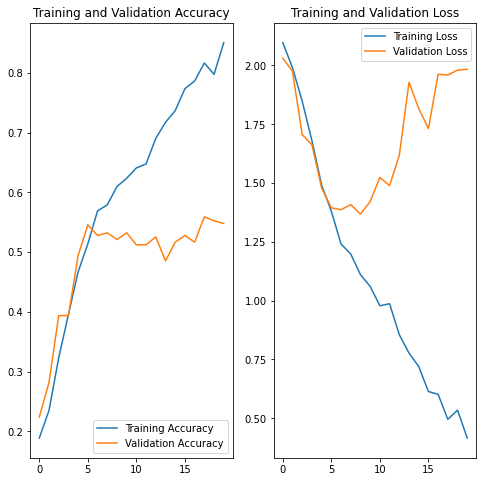

In [43]:
# Lets visualize the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Training and Validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **<font color="blue">Inference:- </font>**
- **<font color="red">As we can see, the model is clearly overfitting, with 85% and 55% training and validation accuracies</font>**

### Write your findings here

In [44]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",      # We do the horizontal flip method to augment
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomTranslation(1,.5,fill_mode="reflect",interpolation="bilinear",seed=None,fill_value=0.0),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
  ]
)

In [45]:
data_augmentation

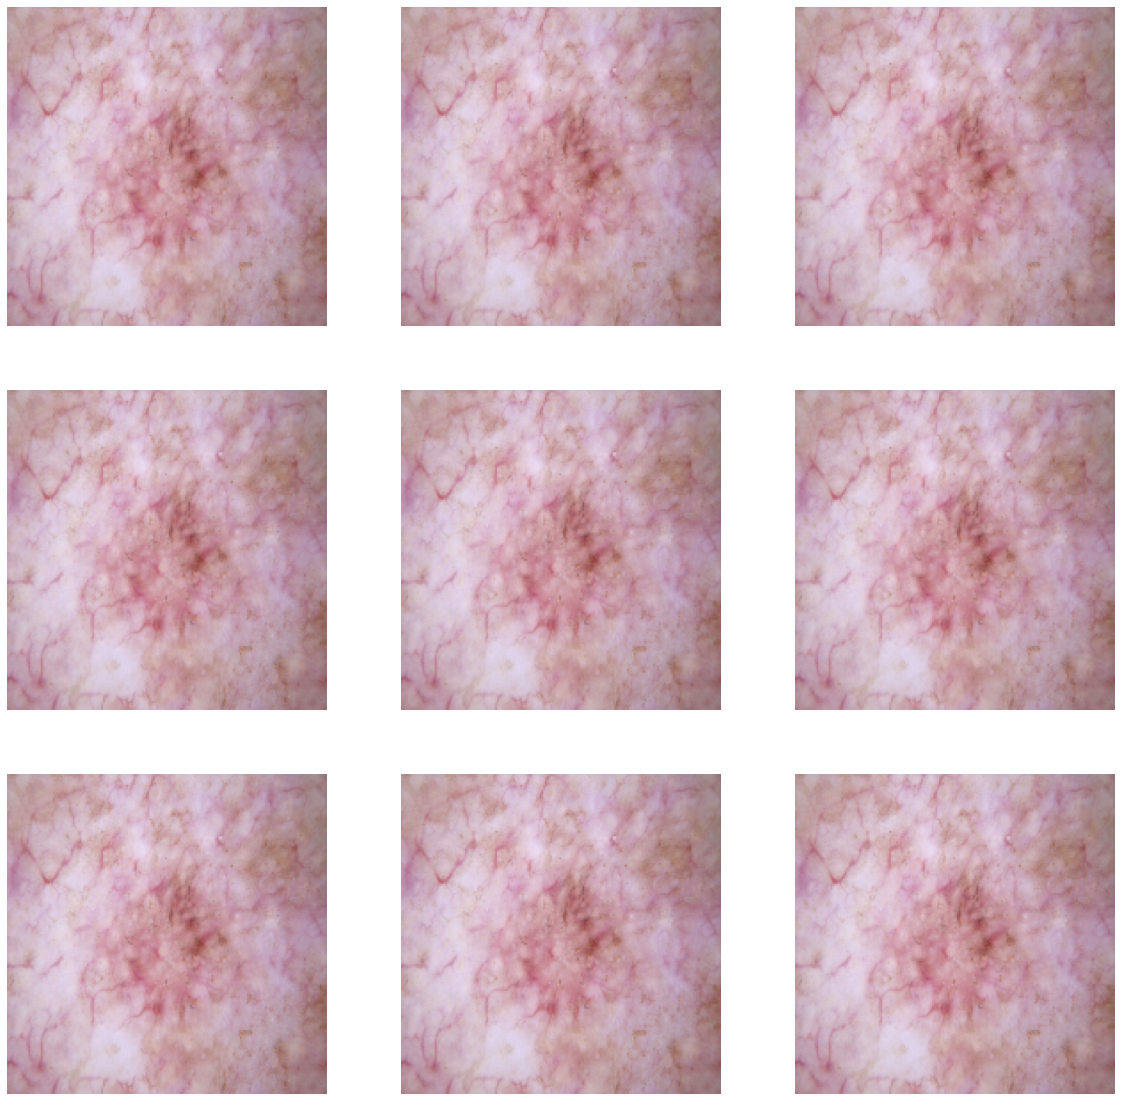

In [46]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(20, 20))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [47]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here
classes_nums = 9
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #We slide over the feature map and extract tiles of a specified size
  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size. 
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #Adding another Pooling layer
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size.
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size. 
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  # Let us add some dropouts
  layers.Dropout(0.25),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer (Dense layer)
  layers.Dense(128, activation='relu'),

  # Output neuron
  layers.Dense(classes_nums)
])


### Compiling the model

In [48]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [49]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)
# history = ## your training code

Epoch 1/20
56/56 [==============================] - 6s 82ms/step - loss: 2.0833 - accuracy: 0.2176 - val_loss: 1.8321 - val_accuracy: 0.3289
Epoch 2/20
56/56 [==============================] - 4s 77ms/step - loss: 1.7613 - accuracy: 0.3292 - val_loss: 1.7271 - val_accuracy: 0.3400
Epoch 3/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6853 - accuracy: 0.3644 - val_loss: 1.6748 - val_accuracy: 0.3647
Epoch 4/20
56/56 [==============================] - 4s 77ms/step - loss: 1.6574 - accuracy: 0.3778 - val_loss: 1.6926 - val_accuracy: 0.3915
Epoch 5/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5866 - accuracy: 0.3979 - val_loss: 1.6444 - val_accuracy: 0.4273
Epoch 6/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5497 - accuracy: 0.4051 - val_loss: 1.6695 - val_accuracy: 0.3803
Epoch 7/20
56/56 [==============================] - 4s 77ms/step - loss: 1.5339 - accuracy: 0.4213 - val_loss: 1.5750 - val_accuracy: 0.4251
Epoch 8/20
56

### Visualizing the results

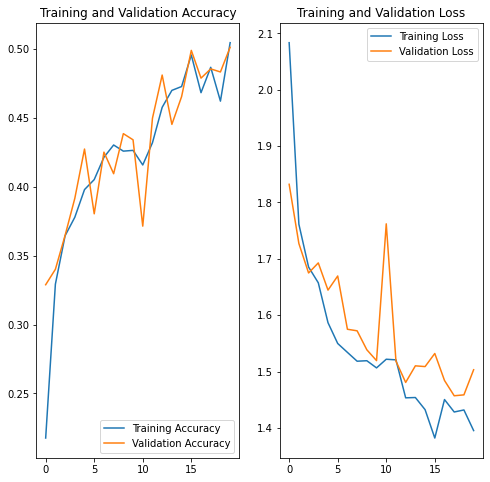

In [50]:
# Lets visualize the above result
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **<font color="blue">Inference:-**
- **</font><font color="red">From above we can infer that, the validation accuracy is catching up with training accuracy. But the overall accuracy is very less for both train and validation. This is a clear case of underfitting with 50% and 50% train and validation accuaracies respectively<font>**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [51]:
## Your code goes here.
# Lets create a list of Path and Label to visualize the Balance in train dataset 
path_list=[]
label_list=[]
for i in class_names:  
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        label_list.append(i)
dataframe_dict_original = dict(zip(path_list, label_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Melanoma Cancer detect...,actinic keratosis
1,/content/gdrive/MyDrive/Melanoma Cancer detect...,actinic keratosis
2,/content/gdrive/MyDrive/Melanoma Cancer detect...,actinic keratosis
3,/content/gdrive/MyDrive/Melanoma Cancer detect...,actinic keratosis
4,/content/gdrive/MyDrive/Melanoma Cancer detect...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Melanoma Cancer detect...,vascular lesion
2235,/content/gdrive/MyDrive/Melanoma Cancer detect...,vascular lesion
2236,/content/gdrive/MyDrive/Melanoma Cancer detect...,vascular lesion
2237,/content/gdrive/MyDrive/Melanoma Cancer detect...,vascular lesion


Class=0, n=114 (5.092%)
Class=1, n=376 (16.793%)
Class=2, n=95 (4.243%)
Class=3, n=438 (19.562%)
Class=4, n=357 (15.945%)
Class=5, n=462 (20.634%)
Class=6, n=77 (3.439%)
Class=7, n=181 (8.084%)
Class=8, n=139 (6.208%)


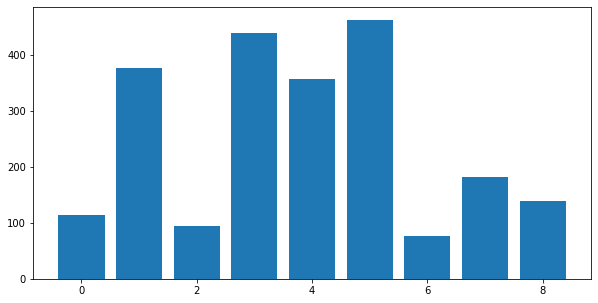

In [52]:
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# split into input and output elements
plt.figure(figsize=(10,5))
X, y = original_df['Path'], original_df['Label']

# label encode the target variable
y = LabelEncoder().fit_transform(y)

# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
- **<font color="red">Seborrheic keratosis has the least number of samples</font>**
#### - Which classes dominate the data in terms proportionate number of samples?
- **<font color="red">Pigmented benign keratosis has the domination on the model as in terms of number of samples</font>**


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [53]:
# Installing Augmentor
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [54]:
# class_names = train_ds.class_names

In [55]:
# Lets add a folder in each input folder called "output" which has the augmented images to get total of 500 images in each classes
path_to_training_dataset="/content/gdrive/MyDrive/Melanoma Cancer detection/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    
    ## We are adding 500 samples per class to make sure that none of the classes are sparse.
    p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EC6C9D310>: 100%|██████████| 500/500 [00:21<00:00, 23.79 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EBA86CC10>: 100%|██████████| 500/500 [00:20<00:00, 23.96 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EC6C7D690>: 100%|██████████| 500/500 [00:22<00:00, 22.36 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EC6CAEED0>: 100%|██████████| 500/500 [01:42<00:00,  4.87 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EC7475F10>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7EC7B12B50>: 100%|██████████| 500/500 [00:18<00:00, 27.56 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7EBA78DD10>: 100%|██████████| 500/500 [00:42<00:00, 11.74 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EC63373D0>: 100%|██████████| 500/500 [00:18<00:00, 27.51 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Melanoma Cancer detection/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7EC617C650>: 100%|██████████| 500/500 [00:17<00:00, 28.14 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [56]:
# data_dir_train_updated = pathlib.Path("/content/gdrive/MyDrive/Melanoma Cancer detection/Train/output")
# image_count_train = len(list(data_dir_train_updated.glob('*/*.jpg')))
# print(image_count_train)

In [57]:
# Lets check the count of the train dataset after augmenation
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [58]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000024.jpg_f66f3fa1-c95e-4983-97e5-d9589cc1259c.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000060.jpg_bc1058c9-aa44-4a42-844f-cf33a3701471.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0027172.jpg_baa3ece5-33c2-432f-a81f-8df4927c0d9c.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000229.jpg_6264f603-3058-457f-aac2-bd6a63dc3b92.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000051.jpg_ed8f6fc7-f6d1-4df0-a6b9-395f3e4f1eee.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000507.jpg_2137ac34-db05-4a84-97e7-6962b9d7aacf.jpg',
 '/content/gdrive/MyDrive/Melanoma Cancer detection/Train/nevus/output/nevus_original_ISIC_0000483.jpg_a928996e-53f4-46b5-8e

In [59]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [60]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [61]:
# Creating the dataframe with Path and Label
new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Melanoma Cancer detect...,nevus
1,/content/gdrive/MyDrive/Melanoma Cancer detect...,nevus
2,/content/gdrive/MyDrive/Melanoma Cancer detect...,nevus
3,/content/gdrive/MyDrive/Melanoma Cancer detect...,nevus
4,/content/gdrive/MyDrive/Melanoma Cancer detect...,nevus
...,...,...
4495,/content/gdrive/MyDrive/Melanoma Cancer detect...,pigmented benign keratosis
4496,/content/gdrive/MyDrive/Melanoma Cancer detect...,pigmented benign keratosis
4497,/content/gdrive/MyDrive/Melanoma Cancer detect...,pigmented benign keratosis
4498,/content/gdrive/MyDrive/Melanoma Cancer detect...,pigmented benign keratosis


In [62]:
# ## Your code goes here.
# # Lets create a list of Path and Label to visualize the Balance in traindataset 
# path_list_new = []
# label_list_new = []
# for i in class_names:  
#     for j in data_dir_train_updated.glob(i+'/*.jpg'):
#         path_list_new.append(str(j))
#         label_list_new.append(i)
# dataframe_dict_new = dict(zip(path_list_new, label_list_new))
# new_df = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
# new_df

In [63]:
# Lets check how many image input are present in each classes
new_df['Label'].value_counts()

nevus                         500
melanoma                      500
dermatofibroma                500
basal cell carcinoma          500
actinic keratosis             500
vascular lesion               500
squamous cell carcinoma       500
seborrheic keratosis          500
pigmented benign keratosis    500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [64]:
batch_size = 32
img_height = 180
img_width = 180

In [65]:
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Melanoma Cancer detection/Train")

In [66]:
# Lets check the count of input in train dataset
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


#### **Todo:** Create a training dataset

In [67]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [68]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [69]:
## Your code goes here
classes_nums = 9
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  #We slide over the feature map and extract tiles of a specified size
  #2D convolution layer (e.g. spatial convolution over images).
  layers.Conv2D(64, 3, padding='same', activation='relu'),

  #Pooling Downsamples the input along its spatial dimensions (height and width) by taking the maximum value over an input window (of size defined by pool_size) for each channel of the input. 
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size. 
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #Adding another Pooling layer
  layers.MaxPooling2D(),

  #We slide over another feature map and extract tiles of a specified size.
  layers.Conv2D(128, 3, padding='same', activation='relu'),

  #We slide over the feature map and extract tiles of a specified size. 
  #Advantages of downsampling - Decreased size of input for upcoming layers, Works against overfitting
  layers.MaxPooling2D(),

  # Let us add some dropouts
  layers.Dropout(0.25),

  #Flattening - Convert into 1D feature vector.  Flattens all its structure to create a single long feature vector
  ##Flattens the input. Does not affect the batch size.
  layers.Flatten(),

  #fully connected layer (Dense layer)
  layers.Dense(128, activation='relu'),

  # Output neuron
  layers.Dense(classes_nums)
])


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [70]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [71]:
## Your code goes here, use 30 epochs.
epochs =30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 33s 186ms/step - loss: 1.8346 - accuracy: 0.2995 - val_loss: 1.5329 - val_accuracy: 0.4143
Epoch 2/30
169/169 [==============================] - 32s 182ms/step - loss: 1.4078 - accuracy: 0.4722 - val_loss: 1.2947 - val_accuracy: 0.5085
Epoch 3/30
169/169 [==============================] - 32s 185ms/step - loss: 1.2386 - accuracy: 0.5299 - val_loss: 1.2013 - val_accuracy: 0.5471
Epoch 4/30
169/169 [==============================] - 32s 182ms/step - loss: 1.0794 - accuracy: 0.6022 - val_loss: 1.1384 - val_accuracy: 0.5976
Epoch 5/30
169/169 [==============================] - 31s 181ms/step - loss: 0.9060 - accuracy: 0.6771 - val_loss: 1.0222 - val_accuracy: 0.6696
Epoch 6/30
169/169 [==============================] - 32s 181ms/step - loss: 0.7460 - accuracy: 0.7251 - val_loss: 1.0112 - val_accuracy: 0.6719
Epoch 7/30
169/169 [==============================] - 31s 181ms/step - loss: 0.6713 - accuracy: 0.7572 - val_loss: 1.0538 - val_ac

#### **Todo:**  Visualize the model results

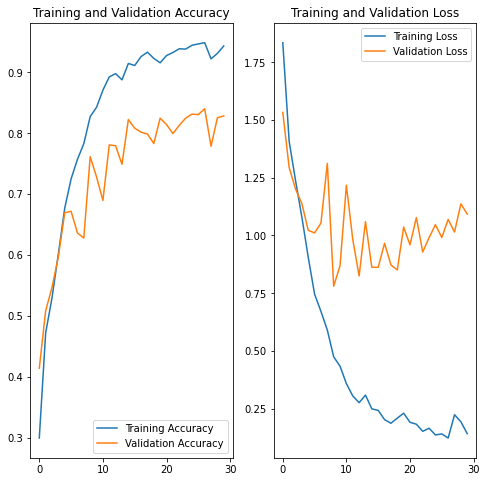

In [72]:
# Lets visualize the model built
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?
**<font color="blue">Inference:- </font><font color="red">**
- **From the above model we can clear say, the above model has solved both the overfit and underfit. The rebalance with Augementor balanced each image classes to a fixed amount (here 500). There by giving equal importance to all the input classes hence this model is a right fit with, 93% and 83% of accuracies of train and validation set respectively.
</font>**
